In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Helper Functions

# Fast Wavelet Transform
def FWT(a,j=0):
    m = int(np.log2(len(a)))

    L = []
    while m > j:
        L.append(0.5 * (a[::2] - a[1::2]))
        a = 0.5 *(a[::2] + a[1::2])
        m -= 1

    return np.concatenate((a, np.concatenate(L[::-1])))

# Define the phi (Haar Son) function which returns 
# 1 when x is within the interval built by j and k
# 0 otherwise
def get_phi(j,k):
    def phi(x):
        if k/2**j <= x < (k+1)/2**j:
            return 1
        else:
            return 0
    return phi

# Define the psi (Haar Daughter) function which returns 
# 1 when x is within the first half interval built by j and k
# -1 when x is within the second half interval
# 0 otherwise
def get_psi(j,k):
    def psi(x):
        if (2*k)/2**(j+1) <= x < (2*k+1)/2**(j+1):
            return 1
        if (2*k+1)/2**(j+1) <= x < (2*k+2)/2**(j+1):
            return -1
        else:
            return 0
    return psi

### Problem 45
Code up a function that takes as input the wavelet transform (given by the array [a00, b00, b10, b11, ...]) and an integer j and returns the approximation Tj[f] in Vj and detail gj in Vj complement as callable functions

Apply the code to function 8.57 and reproduce images in figure 8.20

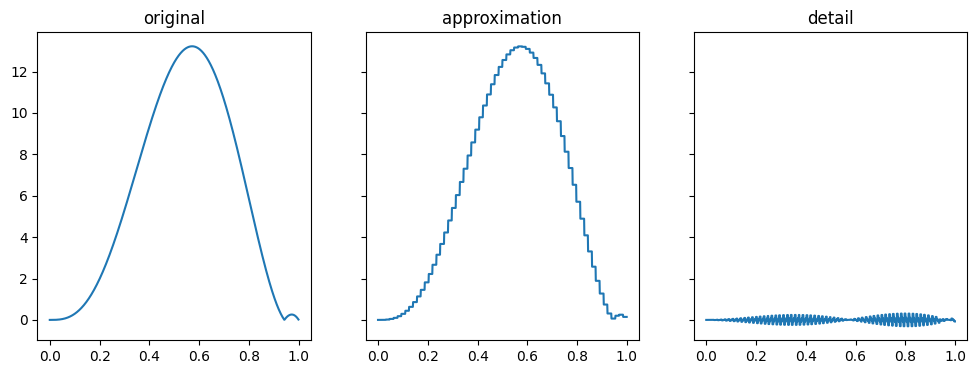

In [9]:
def prob_45(transform_coeffs, j):
    i = int(np.round(np.log2(len(transform_coeffs))))

    approx_coeffs = transform_coeffs[:int(2**j)]
    detail_coeffs = transform_coeffs[int(2**j):]

    phi = get_phi(0,0)

    psis_T = [get_psi(n,m) for n in range(j) for m in range(2**n)]
    psis_g = [get_psi(n,m) for n in range(j,i) for m in range(2**n)]

    def T_j(t):
        a_0_0 = approx_coeffs[0]

        return a_0_0 * phi(t) + sum([b_n_m * psi_n_m(t) for b_n_m, psi_n_m in zip(approx_coeffs[1:], psis_T)])

    def g_j(t):
        return sum([b_n_m * psi_n_m(t) for b_n_m, psi_n_m in zip(detail_coeffs, psis_g)])

    return np.vectorize(T_j), np.vectorize(g_j)

f = lambda t: 100*t**2*(1-t)*abs(np.sin(10*t/3))

sample_points = np.linspace(0,1,2**8, endpoint=False)
a = f(sample_points)

transform_coeffs = FWT(a)

T_6, g_6 = prob_45(transform_coeffs, 6)

fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

t = np.linspace(0, 1, 1000, endpoint=False)
axs[0].plot(t,f(t))
axs[0].set_title("original")
axs[1].plot(t, T_6(t))
axs[1].set_title("approximation")
axs[2].plot(t, g_6(t))
axs[2].set_title("detail")

plt.show()

### Problem 46
(i) Use code from Exercise 8.42 and Exercise 8.45 to construct a method that takes a function f defined on [0, 1) a positive integer l and a positive integer j < l, samples f to get an approximation fl and returns the two functions Tj[f] in Vj and detail gj in Vj complement such that fl = Tj[f] + gj

(ii) Apply your methods to the function (8.99) for l = 10. For each value of j in {0, 1, ..., l - 1} plot each of the functions Tj[f] and gj.

(iii) Compare these plots of each Tj[f] to the corresponding plots in Exercise 8.42.  In both cases they are function in Vj, but they are not identical.  Explain the difference.  Explain why it occurs.

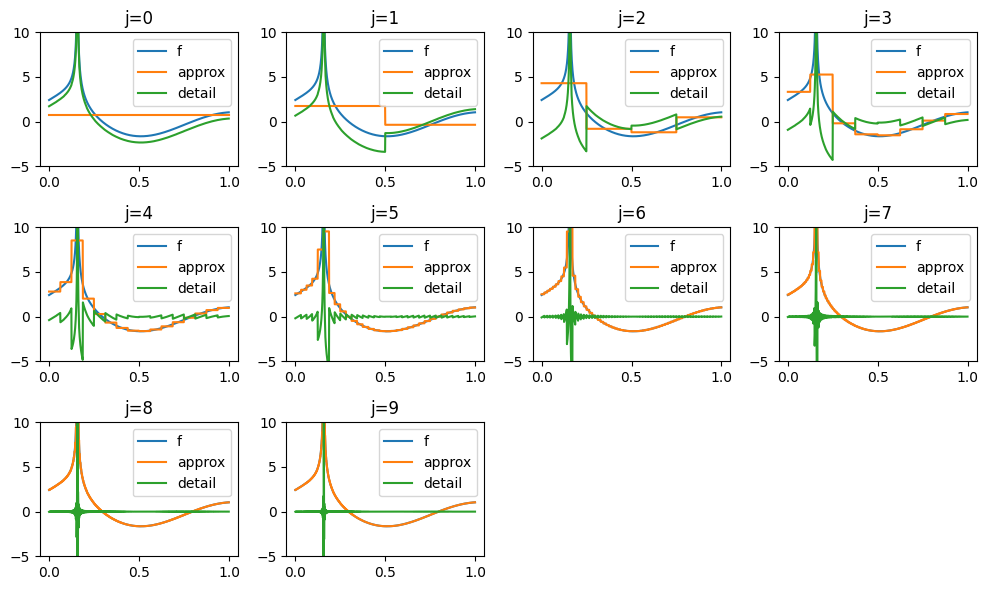

In [10]:
# Code for parts i and ii - see comment after graphs for iii

def prob_46(f,l,j):
    sample_points = np.linspace(0,1,2**l, endpoint=False)
    a = f(sample_points)

    transform_coeffs = FWT(a)

    T_j, g_j = prob_45(transform_coeffs, j)

    return T_j, g_j

f = lambda t: np.sin(2*np.pi*t-5) / np.sqrt(abs(t-np.pi/20))
l = 10
t = np.linspace(0,1,1000, endpoint=False)
plt.figure(figsize=(10,6))

for j in range(l):
    plt.subplot(3,4,j+1)
    plt.title(f"j={j}")
    plt.ylim(-5,10)
    fj,gj = prob_46(f,l,j)
    plt.plot(t, f(t), label="f")
    plt.plot(t, fj(t), label="approx")
    plt.plot(t, gj(t), label="detail")
    plt.legend()

plt.tight_layout()
plt.show()

(iii) Back in problem 42 we projected directly onto Vj so it was the closest approximation of f under Vj.  Here in problem 46 though, we're projecting onto a V10 (since l = 10) and taking the Vj portion of it so it will be an approximation of an approximation.

### Problem 47

(i) Adapt your code from the previous problem to sample functions on any compact interval [a, b], construct the Haar wavelet transform of the sampled function on that interval, and return the two function Tj[f] in Vj and gj in Vj complement such that fl = Tj[f] + gj.

(ii) Apply your method to the function (8.99) on the interval [-1, 1] for l = 10.  For each value of j in {0, 1, ..., l - 1} plot each of the functions Tj[f] and gj

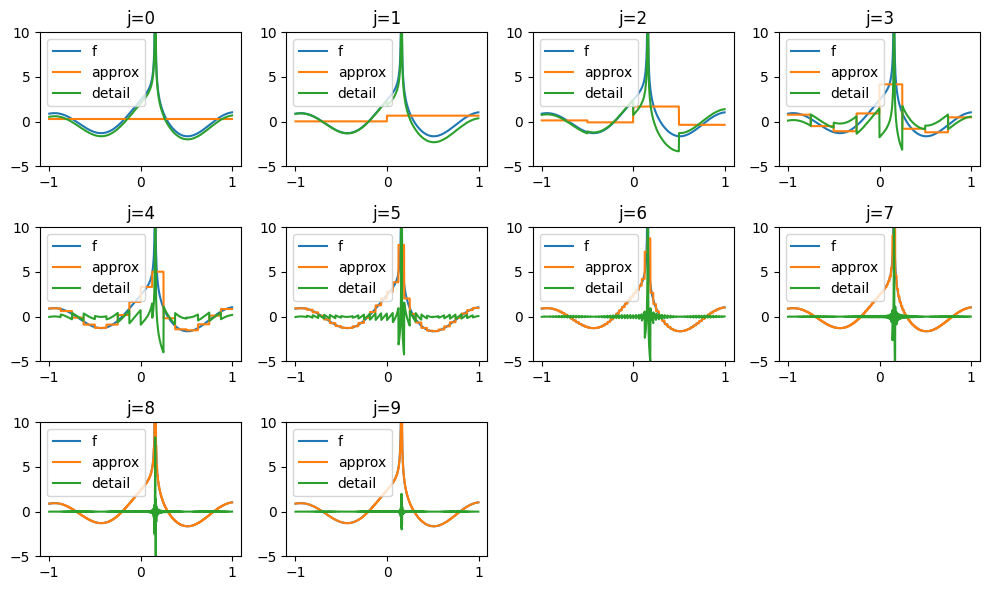

In [14]:
# Code for parts i and ii
def prob_47(f,l,j,a,b):
    fl = lambda x: f(x*(b-a)+a)
    sample_x_vals = np.linspace(0,1,2**l, endpoint=False)
    sample_y_vals = fl(sample_x_vals)

    transform_coeffs = FWT(sample_y_vals)

    T_j, g_j = prob_45(transform_coeffs, j)

    def T(x):
        return T_j((x-a)/((b-a)))

    def g(x):
        return g_j((x-a)/((b-a)))

    return T, g

f = lambda t: np.sin(2*np.pi*t-5) / np.sqrt(abs(t-np.pi/20))
l = 10
a = -1
b = 1
t = np.linspace(a,b,1000, endpoint=False)
plt.figure(figsize=(10,6))

for j in range(l):
    plt.subplot(3,4,j+1)
    plt.title(f"j={j}")
    plt.ylim(-5,10)
    fj,gj = prob_47(f,l,j,a,b)
    plt.plot(t, f(t), label="f")
    plt.plot(t, fj(t), label="approx")
    plt.plot(t, gj(t), label="detail")
    plt.legend()

plt.tight_layout()
plt.show()